# Analysis of Earth's Mixing Ratio

In this notebook, we explore the utility of using a constant Earth mixing ratio as a "first-order approximation" for scenarios where the actual mixing ratio is non-constant. We specifically aim to demonstrate that this approximation can significantly facilitate the implementation of a multiregression model. By maintaining a constant mixing ratio, we reduce the complexity of the input variables and enhance the model's ability to focus on pattern recognition and feature extraction.

# Imports

In [ ]:
import msgpack                          
import numpy as np                      
import pandas as pd                     
from matplotlib import pyplot as plt    
from collections import OrderedDict  

from geexhp.pypsg import PSG
from geexhp import datavis, datamod, datagen
datavis.configure_matplotlib()

2024-11-10 21:34:31.056908: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-10 21:34:31.057458: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-10 21:34:31.059536: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-10 21:34:31.065505: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-10 21:34:31.075759: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

# Present Earth

In [2]:
# Default HabEx Configuration Loading
with open("../geexhp/resources/default_habex.config", "rb") as f:
    config = OrderedDict(msgpack.unpack(f, raw=False))

# Earth with constant mixing ratio

In [ ]:
dg = datagen.DataGen(url="http://127.0.0.1:3000/api.php", stage="modern")
config_constant = dg.config
datamod.mixing_ratio_constant(config_constant, 60)

Testing connection to PSG at http://127.0.0.1:3000/api.php ...
Connected to PSG with success.


# Run PSG

In [4]:
psg = PSG(server_url= "http://127.0.0.1:3000/api.php", timeout_seconds = 200)

Testing connection to PSG at http://127.0.0.1:3000/api.php ...
Connected to PSG with success.


In [5]:
def test_instrument(config, instrument):
    datamod.set_instrument(config, instrument)
    result = psg.run(config)
    columns = [f"WAVELENGTH_{instrument}", f"ALBEDO_{instrument}"]
    return pd.DataFrame(result["spectrum"][:, [0, 1]], columns=columns)

# Define instrument groups for testing
instrument_groups = {
    "main": ["B-NIR", "B-UV", "B-Vis"],
    "secondary": ["SS-NIR", "SS-UV", "SS-Vis"]
}

# Generate DataFrames for each instrument group
results = {}
for group_name, instruments in instrument_groups.items():
    results[group_name] = {
        "normal": pd.concat([test_instrument(config.copy(), instrument) for instrument in instruments]).reset_index(drop=True),
        "constant": pd.concat([test_instrument(config_constant.copy(), instrument) for instrument in instruments]).reset_index(drop=True)
    }

# Access DataFrames using keys
main_df = results["main"]["normal"]
main_df_constant = results["main"]["constant"]
secondary_df = results["secondary"]["normal"]
secondary_df_constant = results["secondary"]["constant"]

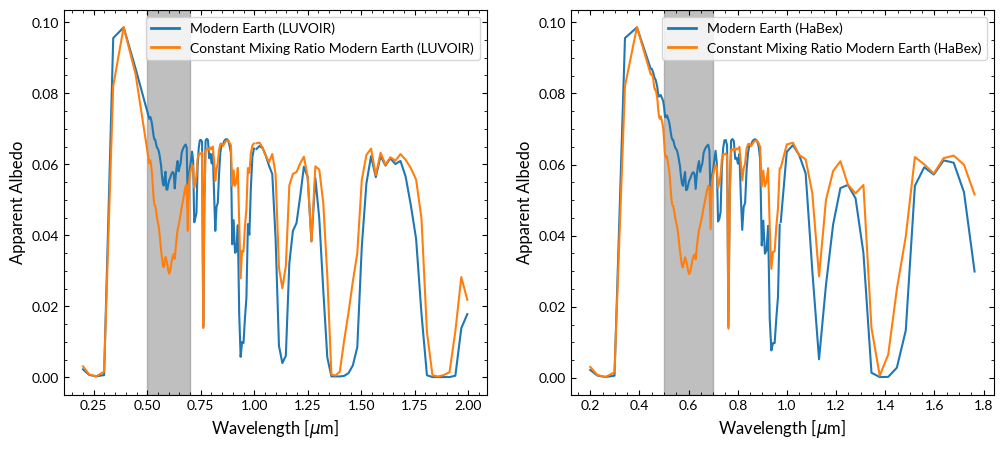

In [6]:
from matplotlib.lines import Line2D

_, axs = plt.subplots(1, 2, figsize=(12, 5))

datavis.plot_spectrum(main_df, label=None, instruments=instrument_groups["main"], ax=axs[0], color="tab:blue")
datavis.plot_spectrum(main_df_constant, label=None, instruments=instrument_groups["main"], ax=axs[0], color="tab:orange")

datavis.plot_spectrum(secondary_df, label=None, instruments=instrument_groups["secondary"], ax=axs[1], color="tab:blue")
datavis.plot_spectrum(secondary_df_constant, label=None, instruments=instrument_groups["secondary"], ax=axs[1], color="tab:orange")

legend_elements = [
    Line2D([0], [0], color='tab:blue', lw=2, label='Modern Earth (LUVOIR)'),
    Line2D([0], [0], color='tab:orange', lw=2, label='Constant Mixing Ratio Modern Earth (LUVOIR)')
]
axs[0].legend(handles=legend_elements)

legend_elements_ss = [
    Line2D([0], [0], color='tab:blue', lw=2, label='Modern Earth (HaBex)'),
    Line2D([0], [0], color='tab:orange', lw=2, label='Constant Mixing Ratio Modern Earth (HaBex)')
]
axs[1].legend(handles=legend_elements_ss)

axs[0].axvspan(0.5, 0.7, color='gray', alpha=0.5)
axs[1].axvspan(0.5, 0.7, color='gray', alpha=0.5);